<a href="https://colab.research.google.com/github/DavianYang/paper2synthesis/blob/main/evidence_synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents

*   [Overview](#overview)
*   [Software Requirements](#software-requirements)
*   [Data Source](#data-source)
*   [Data Exploration](#data-exploration)
*   [Model Pipeline](#model-pipeline)

<a name="overview"></a>
# Overview

It’s crucial for lawmakers, regulators, and policymakers to base climate decisions on scientific evidence and to assess current climate policies through the lens of this evidence. Evaluating climate policies helps improve regulations, fosters transparency, and builds public trust. It also motivates both public and private sectors to make commitments and take stronger actions.

Academic research offers valuable insights for climate policy evaluation. With the vast amount of scientific studies available, it's important to systematically review and summarize the current scientific understanding. The first step in this process is to identify the most relevant studies for specific policies.

In this notebook, I'll demonstrate how Natural Language Processing (NLP) can be used to identify and map climate-related research using a supervised learning approach.

Here’s the structure of the notebook:
1. First, I’ll explore the dataset and create a basic machine learning pipeline.
2. Next, I’ll train a more advanced model using a supervised SVM classifier.
3. Finally, I’ll train and evaluate pretrained transformer models.

## Problem: The Challenge of Comprehensive Assessments

In the past, early IPCC reports dealt with only a few hundred or thousand studies on climate change. However, in the most recent assessment, over 300,000 studies were published on the subject ([Callaghan et al., 2020](https://www.nature.com/articles/s41558-019-0684-5)). While these reports have expanded in terms of authors, pages, and references, they haven't kept pace with the sheer growth in the available literature. As a result, the IPCC now cites a much smaller portion of the relevant studies, raising important questions about which studies are chosen and how they are selected.

## Evidence Synthesis Methods

Evidence synthesis refers to a set of structured methods used to select and assess evidence related to a specific research question. This approach is commonly used in fields like medicine, where major decisions, often involving life-or-death outcomes, are not based on a single study or informal reviews. In traditional literature reviews, experts summarize studies without a formal process for how the evidence is chosen or evaluated.

Evidence synthesis methods aim to ensure that the assessment covers all relevant evidence comprehensively, with a focus on transparency in how studies are identified, selected, and assessed.


## Machine Learning-Assisted Evidence Synthesis

Many aspects of evidence synthesis, such as screening relevant studies or categorizing them based on the type of evidence they provide, can be repetitive and time-consuming. As the number of studies grows, these tasks become even more challenging, making it difficult to create thorough assessments.

Machine learning (ML) can help with these repetitive tasks, especially since research is primarily documented in text format. Natural Language Processing (NLP) tools, a branch of machine learning, can assist with automating these processes.

Some current applications of ML in evidence synthesis include:

- **Identifying relevant studies**: A simple binary classifier can be trained using human-screened data (with studies labeled as relevant or not) to predict whether new, unlabeled studies are relevant.
- **Classifying studies**: Machine learning can also be used to assign useful labels to studies. This can be done through:
  - **Unsupervised methods** (e.g., topic modeling), which don't require human input but can't categorize documents into predefined labels.
  - **Supervised methods**, where ML models predict labels for unseen documents based on labels assigned by humans.

In my notebook, I will explore how supervised learning methods can be applied to identify and classify evidence on climate impacts, following a simplified version of the pipeline used in this [publication](https://www.nature.com/articles/s41558-021-01168-6.epdf?sharing_token=7Sw0J3PwoQNKriW6TbOuX9RgN0jAjWel9jnR3ZoTv0PwAcRfhcoupIk0A95eY8_-YUKjuCHE46BRE8RXMy_HNaRNTl48Ji0i6-pYLEd3WbQwXQpTp1LscjrMM5Am67huate7yo35BOmH8Yq08b_CuYEhHpq1-SwJh0A5XD6kKvE%3D).

<a name="software-requirements"></a>
# Software Requirements
This notebook requires the following libraries:
*   datasets (pip)
*   transformers (pip)

`datasets` is a library which we will use to download the data required.
`transformers` is a library which we will use to load pre-trained language models from.

The package is written using `PyTorch` and `sklearn` machine learning libraries.

<a name="data-source"></a>
# Data Source

In [1]:
!pip install gdown
!gdown 1pq9meLLvUPEdv0vMEmBG3oBi4nOVhtv1
!gdown 1wag2aMwabrFvNUrtvvkhafxw7bstLqgf

Downloading...
From: https://drive.google.com/uc?id=1pq9meLLvUPEdv0vMEmBG3oBi4nOVhtv1
To: /content/openalex_data.csv
100% 28.1M/28.1M [00:00<00:00, 33.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wag2aMwabrFvNUrtvvkhafxw7bstLqgf
To: /content/labelled_data.csv
100% 4.45M/4.45M [00:00<00:00, 35.9MB/s]


In [2]:
!pip install datasets
!pip install transformers
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


<a name="data-exploration"></a>
# Data Exploration

We have preprocessed and prepared two sources of data:

  - labeled_data: which contains "INCLUDE" where 1 means the study was used in the synthesis report, and 0 means it was not.
  - unlabeled_data: which contains studies from the OpenAlex database. All studies in the labeled_data are "seen", since a human has reviewed them all to conclude whether to include them in the report or not. The unlabeled_data is unseen (seen=0), since they were not reviewed by a human.

Lets download the data and have a look at it.

In [3]:
import pandas as pd
import numpy as np


unlabeled_data = pd.read_csv('openalex_data.csv')
print(f'The dataset has {unlabeled_data.shape[0]} rows and {unlabeled_data.shape[1]} columns')
print(f'The columns are: {unlabeled_data.columns.values}')
unlabeled_data.head()

The dataset has 24906 rows and 6 columns
The columns are: ['id' 'doi' 'title' 'publication_year' 'abstract' 'authors']


,id,doi,title,publication_year,abstract,authors
0,https://openalex.org/W2076977109,https://doi.org/10.1038/nature03906,Increasing destructiveness of tropical cyclone...,2005,NaN,Kerry Emanuel
1,https://openalex.org/W2171979944,https://doi.org/10.1007/s00425-003-1105-5,"Plant responses to drought, salinity and extre...",2003,NaN,"Wang-Xia Wang, Basia Vinocur, Arie Altman"
2,https://openalex.org/W2122582889,https://doi.org/10.1073/pnas.0505734102,Regional vegetation die-off in response to glo...,2005,Future drought is projected to occur under war...,"David D. Breshears, Neil S. Cobb, Paul Rich, K..."
3,https://openalex.org/W2170327428,https://doi.org/10.1073/pnas.1422385112,Anthropogenic warming has increased drought ri...,2015,Significance California ranks first in the Uni...,"Noah S. Diffenbaugh, Daniel L. Swain, Danielle..."
4,https://openalex.org/W2154180993,https://doi.org/10.1038/nature04188,Impact of regional climate change on human health,2005,NaN,"Jonathan A. Patz, Diarmid Campbell-Lendrum, Tr..."


Understanding the OpenAlex Dataset (unlabeled_data)

  - Each row corresponds to an academic paper and has some columns with metadata like the publication year, list of authors, etc.
  - The important columns that we will use are
      - 'abstract' and the 'title' which is string text.
      - A unique identifier called 'id'.
      - And some metadata like 'publication_year', 'authors', 'doi'.


## Basic Exploration

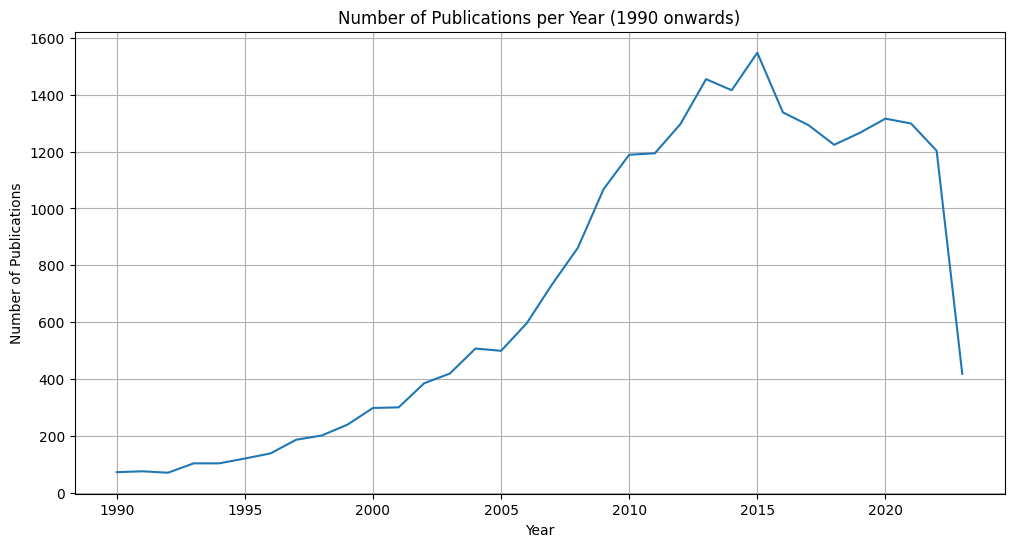

In [4]:
import matplotlib.pyplot as plt

# Convert the 'publication_year' column to numeric, handling potential errors
unlabeled_data['publication_year'] = pd.to_numeric(unlabeled_data['publication_year'], errors='coerce')

# Filter the DataFrame for years starting from 1990
publications_after_1990 = unlabeled_data[unlabeled_data['publication_year'] >= 1990]

# Group by publication year and count the number of publications
publications_per_year = publications_after_1990.groupby('publication_year')['id'].count()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(publications_per_year.index, publications_per_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.title('Number of Publications per Year (1990 onwards)')
plt.grid(True)
plt.show()

## Labelled Dataset

In [5]:
labelled_data = pd.read_csv('labelled_data.csv')
print(f'The dataset has {labelled_data.shape[0]} rows and {labelled_data.shape[1]} columns')
print(f'The columns are: {labelled_data.columns.values}')
labelled_data.head()

The dataset has 2500 rows and 10 columns
The columns are: ['id' 'abstract' 'title' 'seen' 'INCLUDE'
 '12 - Coastal and marine Ecosystems' '12 - Human and managed'
 '12 - Mountains, snow and ice' '12 - Rivers, lakes, and soil moisture'
 '12 - Terrestrial ES']


,id,abstract,title,seen,INCLUDE,12 - Coastal and marine Ecosystems,12 - Human and managed,"12 - Mountains, snow and ice","12 - Rivers, lakes, and soil moisture",12 - Terrestrial ES
0,1448689,"The city of Bismarck, North Dakota has one of ...",Key Factors Influencing the Incidence of West ...,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,3281128,Changing precipitation regimes can profoundly ...,Asymmetric responses of plant community struct...,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,900708,Climate influences forest structure through ef...,Climate effects on fire regimes and tree recru...,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,3234419,"Climate change is likely to bring more, hotter...",Climate change adaptation and mitigation ? a h...,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4,2090028,Aim The long-term stability of coastal ecosyst...,Caribbean mangroves adjust to rising sea level...,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [6]:
import re

def clean_title(title):
  if isinstance(title, str):
    title = re.sub(r'\W', '', title).lower()
    title = title.replace(" ", "")
  return title

# We create a column of lower case version of title without space and punctuation
labelled_data['cleaned_title'] = labelled_data['title'].apply(clean_title)

# We get rid of documents without abstracts
labelled_data = labelled_data.dropna(subset=['abstract'])
print(f"Number of rows/columns after removing documents without abstracts: {labelled_data.shape}")

labelled_data.head()

Number of rows/columns after removing documents without abstracts: (2500, 11)


,id,abstract,title,seen,INCLUDE,12 - Coastal and marine Ecosystems,12 - Human and managed,"12 - Mountains, snow and ice","12 - Rivers, lakes, and soil moisture",12 - Terrestrial ES,cleaned_title
0,1448689,"The city of Bismarck, North Dakota has one of ...",Key Factors Influencing the Incidence of West ...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,keyfactorsinfluencingtheincidenceofwestnilevir...
1,3281128,Changing precipitation regimes can profoundly ...,Asymmetric responses of plant community struct...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,asymmetricresponsesofplantcommunitystructurean...
2,900708,Climate influences forest structure through ef...,Climate effects on fire regimes and tree recru...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,climateeffectsonfireregimesandtreerecruitmenti...
3,3234419,"Climate change is likely to bring more, hotter...",Climate change adaptation and mitigation ? a h...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,climatechangeadaptationandmitigationahitherton...
4,2090028,Aim The long-term stability of coastal ecosyst...,Caribbean mangroves adjust to rising sea level...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,caribbeanmangrovesadjusttorisingsealevelthroug...


In [7]:
# We load openalex datasest and process the same as labelled dataset for merging
unlabeled_data = unlabeled_data.rename(columns={"id": "OA_id"})
unlabeled_data["cleaned_title"] = unlabeled_data["title"].apply(clean_title)
unlabeled_data = unlabeled_data.dropna(subset=["abstract"]).copy()
unlabeled_data.loc[:, "seen"] = 0;
print(f'The dataset has {unlabeled_data.shape[0]} rows and {unlabeled_data.shape[1]} columns')
print(f'The columns are: {unlabeled_data.columns.values}')
unlabeled_data.head()

The dataset has 18556 rows and 8 columns
The columns are: ['OA_id' 'doi' 'title' 'publication_year' 'abstract' 'authors'
 'cleaned_title' 'seen']


,OA_id,doi,title,publication_year,abstract,authors,cleaned_title,seen
2,https://openalex.org/W2122582889,https://doi.org/10.1073/pnas.0505734102,Regional vegetation die-off in response to glo...,2005,Future drought is projected to occur under war...,"David D. Breshears, Neil S. Cobb, Paul Rich, K...",regionalvegetationdieoffinresponsetoglobalchan...,0
3,https://openalex.org/W2170327428,https://doi.org/10.1073/pnas.1422385112,Anthropogenic warming has increased drought ri...,2015,Significance California ranks first in the Uni...,"Noah S. Diffenbaugh, Daniel L. Swain, Danielle...",anthropogenicwarminghasincreaseddroughtriskinc...,0
6,https://openalex.org/W2145638163,https://doi.org/10.1098/rstb.2010.0021,Community and ecosystem responses to recent cl...,2010,There is ample evidence for ecological respons...,Gian-Reto Walther,communityandecosystemresponsestorecentclimatec...,0
7,https://openalex.org/W2120998920,https://doi.org/10.1016/j.tree.2004.07.021,Emerging infectious diseases of plants: pathog...,2004,Emerging infectious diseases (EIDs) pose threa...,"Pamela Sue Anderson, Andrew A. Cunningham, Nik...",emerginginfectiousdiseasesofplantspathogenpoll...,0
8,https://openalex.org/W2085588880,https://doi.org/10.1111/j.1365-2486.2007.01404.x,"Influences of species, latitudes and methodolo...",2007,New analyses are presented addressing the glob...,Camille Parmesan,influencesofspecieslatitudesandmethodologieson...,0


Merge labelled dataset and unlabelled datasets matching cleaned_title

In [8]:
df = pd.concat([labelled_data, unlabeled_data[~unlabeled_data['cleaned_title'].isin(labelled_data['cleaned_title'])]])
print(df.shape)
df.head()

(20771, 15)


,id,abstract,title,seen,INCLUDE,12 - Coastal and marine Ecosystems,12 - Human and managed,"12 - Mountains, snow and ice","12 - Rivers, lakes, and soil moisture",12 - Terrestrial ES,cleaned_title,OA_id,doi,publication_year,authors
0,1448689.0,"The city of Bismarck, North Dakota has one of ...",Key Factors Influencing the Incidence of West ...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,keyfactorsinfluencingtheincidenceofwestnilevir...,NaN,NaN,NaN,NaN
1,3281128.0,Changing precipitation regimes can profoundly ...,Asymmetric responses of plant community struct...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,asymmetricresponsesofplantcommunitystructurean...,NaN,NaN,NaN,NaN
2,900708.0,Climate influences forest structure through ef...,Climate effects on fire regimes and tree recru...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,climateeffectsonfireregimesandtreerecruitmenti...,NaN,NaN,NaN,NaN
3,3234419.0,"Climate change is likely to bring more, hotter...",Climate change adaptation and mitigation ? a h...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,climatechangeadaptationandmitigationahitherton...,NaN,NaN,NaN,NaN
4,2090028.0,Aim The long-term stability of coastal ecosyst...,Caribbean mangroves adjust to rising sea level...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,caribbeanmangrovesadjusttorisingsealevelthroug...,NaN,NaN,NaN,NaN


## Inspecting our labels

We can take a quick look at how many of which type of labels we have

Number of seen vs. unseen documents
seen
0.0    18262
1.0     2500
Name: title, dtype: int64
----------------------------------------------------------------------------------------------------
Number of included vs. excluded documents
INCLUDE
0.0    1194
1.0    1306
Name: title, dtype: int64


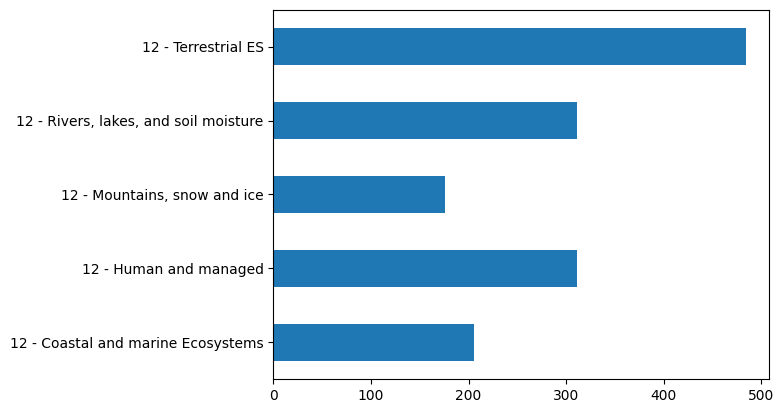

In [9]:
def inspect_labels(df):
  print("Number of seen vs. unseen documents")
  print(df.groupby("seen")["title"].count())

  print("-"*100)

  print("Number of included vs. excluded documents")
  print(df.groupby("INCLUDE")["title"].count())

  # Plotting how many examples of each impact type we have
  df[impacts].sum().plot.barh();

impacts = [x for x in df.columns if re.match("12 -", x)]
inspect_labels(df)

## Train & Test Split function

For training classifiers, it is essential to create a training and testing dataset. Hence, we define the following function:

In [10]:
from sklearn.model_selection import train_test_split

def train_test_split_df(df):
    ''' Gets train/test splits for INCLUDE prediction task.
    '''
    # select only the seen documents
    all_seen = df[df["seen"] == 1].index
    all_x = df[df["seen"] == 1]["abstract"].values
    all_y = df[df["seen"] == 1]["INCLUDE"].values.astype(int)
    train_size = 0.8
    x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, train_size=train_size, random_state=42)
    assert len(x_train) == len(y_train)
    assert len(x_test) == len(y_test)
    print (f"Train size: {len(x_train)}")
    print (f"Test size: {len(x_test)}")
    return x_train, y_train, x_test, y_test

<a name="model-pipeline"></a>
# Model Pipeline

## Using SVM Model

Support Vector Machines (SVM) work by finding a hyperplane in a multi-dimensional space that separates samples of different classes. The matrix we have visualised above forms our multidimensional space. In simple words, an SVM builds a decision boundary between classes. For this, the classes need labels (which the dataset above fortunately has and we will simulate for now).

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

def build_svm(toy_texts, y):
  svm_classifier = Pipeline(
      steps=[
          # Converts raw text into numerical feature vectors using the TF-IDF method
          ("vectorizer", TfidfVectorizer()),
          # probability=True: Enables the classifier to output probabilities using Platt scaling
          # class_weight="balanced": Automatically adjusts the weights for each class to handle imbalanced datasets.
          ("classifier", SVC(probability=True, class_weight="balanced"))
      ]
  )
  svm_classifier.fit(toy_texts, y)
  return svm_classifier

In [12]:
from sklearn.metrics import classification_report

# trains with train data and evalutes the model with test data.
# load the train/test splits
x_train, y_train, x_test, y_test = train_test_split_df(df)
# build the classifier
svm_classifier = build_svm(x_train, y_train)
# get the predictions on the test set
test_pred = svm_classifier.predict(x_test)
# Get the classification evaluation metrics
# This will be covered in more detail later.
print(classification_report(y_test, test_pred))

Train size: 2000
Test size: 500
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       235
           1       0.82      0.87      0.84       265

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



### Saving model SVM Classifier

In [13]:
import pickle

# Assuming 'svm_classifier' is your trained SVM model from the previous code
# Save the model to a file
with open('./svm_model.pkl', 'wb') as file:
    pickle.dump(svm_classifier, file)

# Load the model from the file
with open('./svm_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

new_texts = [
    "Precipitation changes affect plant growth and diversity, with reductions causing greater impacts. A 3-year study found plant cover and richness more sensitive to drought, while diversity indices showed resilience in a semi-arid steppe.",
    "Climate change is impacting human systems",
    "Climate change has affected butterfly phenology in North America",
]

print('predictions:', loaded_model.predict(new_texts))
# Unstable as small datasets, but not guranteed to match prediction
print('probabilities:\n', loaded_model.predict_proba(new_texts))

predictions: [1 0 1]
probabilities:
 [[0.40681829 0.59318171]
 [0.93884314 0.06115686]
 [0.3315104  0.6684896 ]]


### Testing the SVM classifier with Unlabelled Datasets


In [14]:
# Filter out seen documents and documents where INCLUDE is NaN
unseen_data = df[(df["seen"] == 0) & (df["INCLUDE"].isna())].copy()

# Apply the model to predict the INCLUDE field for the filtered data
unseen_data['predicted_INCLUDE'] = loaded_model.predict(unseen_data['abstract'])

# Print information about the number of rows in the filtered data
print(f"Number of updated rows: {len(unseen_data)}")
# Save the datasets
unseen_data.to_csv('svm_predictions_unseen_nan_data.csv', index=False)
unseen_data.head()

Number of updated rows: 18271


,id,abstract,title,seen,INCLUDE,12 - Coastal and marine Ecosystems,12 - Human and managed,"12 - Mountains, snow and ice","12 - Rivers, lakes, and soil moisture",12 - Terrestrial ES,cleaned_title,OA_id,doi,publication_year,authors,predicted_INCLUDE
2,NaN,Future drought is projected to occur under war...,Regional vegetation die-off in response to glo...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,regionalvegetationdieoffinresponsetoglobalchan...,https://openalex.org/W2122582889,https://doi.org/10.1073/pnas.0505734102,2005.0,"David D. Breshears, Neil S. Cobb, Paul Rich, K...",0
3,NaN,Significance California ranks first in the Uni...,Anthropogenic warming has increased drought ri...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,anthropogenicwarminghasincreaseddroughtriskinc...,https://openalex.org/W2170327428,https://doi.org/10.1073/pnas.1422385112,2015.0,"Noah S. Diffenbaugh, Daniel L. Swain, Danielle...",1
6,NaN,There is ample evidence for ecological respons...,Community and ecosystem responses to recent cl...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,communityandecosystemresponsestorecentclimatec...,https://openalex.org/W2145638163,https://doi.org/10.1098/rstb.2010.0021,2010.0,Gian-Reto Walther,1
7,NaN,Emerging infectious diseases (EIDs) pose threa...,Emerging infectious diseases of plants: pathog...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,emerginginfectiousdiseasesofplantspathogenpoll...,https://openalex.org/W2120998920,https://doi.org/10.1016/j.tree.2004.07.021,2004.0,"Pamela Sue Anderson, Andrew A. Cunningham, Nik...",0
8,NaN,New analyses are presented addressing the glob...,"Influences of species, latitudes and methodolo...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,influencesofspecieslatitudesandmethodologieson...,https://openalex.org/W2085588880,https://doi.org/10.1111/j.1365-2486.2007.01404.x,2007.0,Camille Parmesan,0


## Using Multilabel SVM Model

### Different Classes of Impacts

Multilabel problems are those where any sample can belong to any of the classes (as opposed to multiclass problems where each sample must belong to exactly 1 class. In our dataset, most documents which were marked as relevant are assigned to one class, with some assigned to two, and very few assigned to three.

In [15]:
print(impacts)
df[df["INCLUDE"] == 1].head()

['12 - Coastal and marine Ecosystems', '12 - Human and managed', '12 - Mountains, snow and ice', '12 - Rivers, lakes, and soil moisture', '12 - Terrestrial ES']


,id,abstract,title,seen,INCLUDE,12 - Coastal and marine Ecosystems,12 - Human and managed,"12 - Mountains, snow and ice","12 - Rivers, lakes, and soil moisture",12 - Terrestrial ES,cleaned_title,OA_id,doi,publication_year,authors
1,3281128.0,Changing precipitation regimes can profoundly ...,Asymmetric responses of plant community struct...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,asymmetricresponsesofplantcommunitystructurean...,NaN,NaN,NaN,NaN
2,900708.0,Climate influences forest structure through ef...,Climate effects on fire regimes and tree recru...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,climateeffectsonfireregimesandtreerecruitmenti...,NaN,NaN,NaN,NaN
3,3234419.0,"Climate change is likely to bring more, hotter...",Climate change adaptation and mitigation ? a h...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,climatechangeadaptationandmitigationahitherton...,NaN,NaN,NaN,NaN
4,2090028.0,Aim The long-term stability of coastal ecosyst...,Caribbean mangroves adjust to rising sea level...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,caribbeanmangrovesadjusttorisingsealevelthroug...,NaN,NaN,NaN,NaN
5,574391.0,Climate change and habitat destruction have be...,Compounded effects of climate change and habit...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,compoundedeffectsofclimatechangeandhabitatalte...,NaN,NaN,NaN,NaN


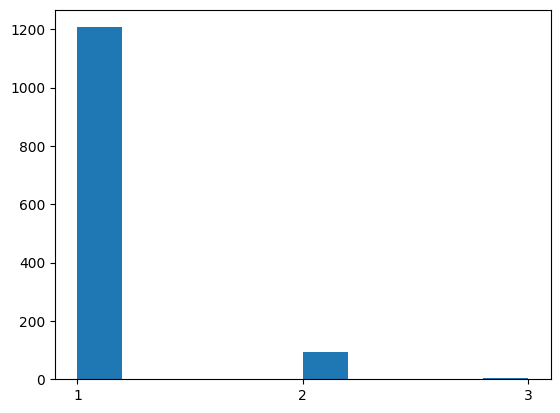

In [16]:
# This plot shows that certain documents have multiple labels for different impacts.
plt.hist(df[df["INCLUDE"] == 1][impacts].sum(axis=1))
plt.xticks(np.arange(1, 4, 1))
plt.show()

In [17]:
import random

idx = df[df["INCLUDE"] == 1].index
X = df.iloc[idx]["abstract"].values
y = df.iloc[idx][impacts].values


for i in range(min(10, len(X))):
  random_index = random.randint(0, len(X) - 1)
  print(f"{i} - X: {X[random_index][:50]}... | y: {y[random_index]}")

0 - X: Climate is well known as an important determinant ... | y: [0. 0. 0. 0. 1.]
1 - X: Understanding what drives the geographic variation... | y: [0. 0. 0. 0. 1.]
2 - X: We used improved datasets on both climate and crop... | y: [0. 1. 0. 0. 0.]
3 - X: Within isolated and fragmented populations, specie... | y: [1. 0. 0. 0. 0.]
4 - X: Under the background of global climate change, hyd... | y: [0. 0. 0. 1. 0.]
5 - X: Background: Heat waves have been reported to be as... | y: [0. 1. 0. 0. 0.]
6 - X: Linear regression and cumulative sum analysis (CUS... | y: [0. 0. 0. 0. 1.]
7 - X: Recent studies have revealed that the effect of te... | y: [0. 1. 0. 0. 0.]
8 - X: The catchments in the Loess Plateau, in China's mi... | y: [0. 0. 0. 1. 0.]
9 - X: In this study, we present a review of the current ... | y: [0. 0. 0. 1. 0.]


In [18]:
# Change SVM for mulit labels
from sklearn.multiclass import OneVsRestClassifier

svm_multi_classifier = Pipeline(
      steps=[
          ("vectorizer", TfidfVectorizer()),
          ("classifier", OneVsRestClassifier(SVC(probability=True, class_weight="balanced")))
      ]
  )

svm_multi_classifier.fit(X, y)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 OneVsRestClassifier(estimator=SVC(class_weight='balanced',
                                                   probability=True)))])

### Saving Model SVM Multi Classifier

In [19]:
import pickle

with open('./svm_multi_model.pkl', 'wb') as file:
    pickle.dump(svm_multi_classifier, file)

# Load the model from the file (example)
with open('./svm_multi_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

example_texts = [
    # First text
    "Climate change has affected butterfly phenology in North America. "
    + "In an experiment in the butterfly national park, we found that "
    + "mean dates of appearance had shifted by two weeks. Species traits, "
    + "especially ecological traits, were found to explain some part of "
    + "different phenological responses",

    # Second text
    "Rising temperatures have contributed to increasing heat related mortaility "
    + "in cities across Europe. ",
]


y_pred = loaded_model.predict(example_texts)
pd.DataFrame(y_pred, columns=impacts)

,12 - Coastal and marine Ecosystems,12 - Human and managed,"12 - Mountains, snow and ice","12 - Rivers, lakes, and soil moisture",12 - Terrestrial ES
0,0,0,0,0,1
1,0,1,0,0,0


### Testing SVM Multi Classifier Model with Unlabelled Dataset

In [20]:
unseen_data = df[(df["seen"] == 0) & (df["INCLUDE"].isna())].copy()

unseen_abstracts = unseen_data['abstract'].values

predicted_impacts = loaded_model.predict(unseen_abstracts)
predicted_impacts_df = pd.DataFrame(predicted_impacts, columns=impacts)

In [21]:
for column in impacts:
    unseen_data[column] = predicted_impacts_df[column]

unseen_data.to_csv('svm_multi_predictions_unseen_nan_data.csv', index=False)
unseen_data.head()

,id,abstract,title,seen,INCLUDE,12 - Coastal and marine Ecosystems,12 - Human and managed,"12 - Mountains, snow and ice","12 - Rivers, lakes, and soil moisture",12 - Terrestrial ES,cleaned_title,OA_id,doi,publication_year,authors
2,NaN,Future drought is projected to occur under war...,Regional vegetation die-off in response to glo...,0.0,NaN,0.0,0.0,0.0,0.0,1.0,regionalvegetationdieoffinresponsetoglobalchan...,https://openalex.org/W2122582889,https://doi.org/10.1073/pnas.0505734102,2005.0,"David D. Breshears, Neil S. Cobb, Paul Rich, K..."
3,NaN,Significance California ranks first in the Uni...,Anthropogenic warming has increased drought ri...,0.0,NaN,0.0,1.0,0.0,0.0,0.0,anthropogenicwarminghasincreaseddroughtriskinc...,https://openalex.org/W2170327428,https://doi.org/10.1073/pnas.1422385112,2015.0,"Noah S. Diffenbaugh, Daniel L. Swain, Danielle..."
6,NaN,There is ample evidence for ecological respons...,Community and ecosystem responses to recent cl...,0.0,NaN,0.0,1.0,0.0,0.0,0.0,communityandecosystemresponsestorecentclimatec...,https://openalex.org/W2145638163,https://doi.org/10.1098/rstb.2010.0021,2010.0,Gian-Reto Walther
7,NaN,Emerging infectious diseases (EIDs) pose threa...,Emerging infectious diseases of plants: pathog...,0.0,NaN,0.0,0.0,0.0,0.0,1.0,emerginginfectiousdiseasesofplantspathogenpoll...,https://openalex.org/W2120998920,https://doi.org/10.1016/j.tree.2004.07.021,2004.0,"Pamela Sue Anderson, Andrew A. Cunningham, Nik..."
8,NaN,New analyses are presented addressing the glob...,"Influences of species, latitudes and methodolo...",0.0,NaN,0.0,0.0,0.0,0.0,0.0,influencesofspecieslatitudesandmethodologieson...,https://openalex.org/W2085588880,https://doi.org/10.1111/j.1365-2486.2007.01404.x,2007.0,Camille Parmesan


The bar chart shows most instances (~13,000) have no labels, ~5,000 have one label, and none have two or more. This suggests the classifier struggles to predict multiple labels.

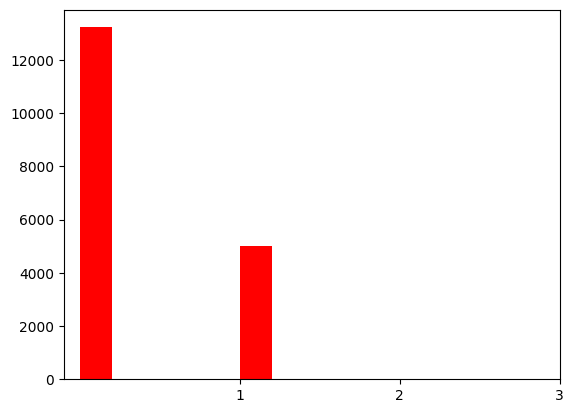

In [22]:
plt.hist(unseen_data[impacts].sum(axis=1), color='red')
plt.xticks(np.arange(1, 4, 1))
plt.show()

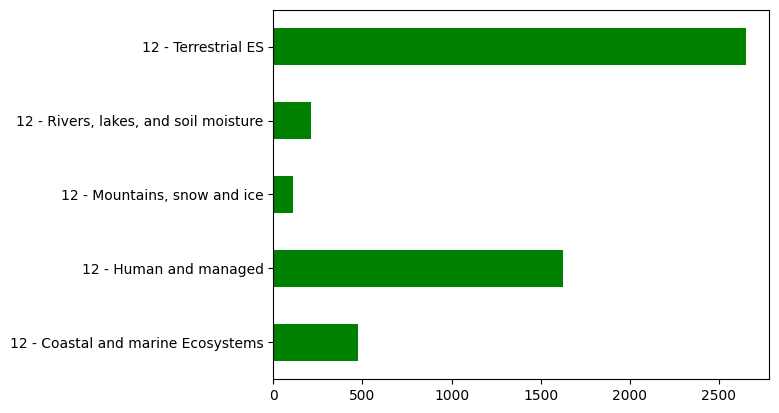

In [23]:
unseen_data[impacts].sum().plot.barh(color='green');

## Using ClimateBERT Transformer

A more powerful way to do classification is to fine-tune a langauge model which has been pretrained on large amounts of text.

The Transformers library makes doing this really easy, and there are a wealth of models available with different features and which have been pretrained on different corpora. We are going to use ClimateBert, which has undergone additional pretraining on texts from the climate domain (included scientific articles).

Thus, a decisive difference to before is that ClimateBERT already learned understanding "language", i.e., the features we extracted from the text before. ClimateBERT fine-tuning will only enable the language-understanding model to learn by example.

In [24]:
import torch
from datasets import Dataset
from transformers import AutoTokenizer
from torch import tensor
from torch.nn import Sigmoid, Softmax
from transformers import AutoModelForSequenceClassification, Trainer, logging
from torch.nn import functional as F

model_name = "climatebert/distilroberta-base-climate-f"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.15M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [25]:
# We can wrap this into one function that turns any set of texts (and optional labels)
# into a tokenized huggingface dataset
def datasetify(x, tokenizer, y=None):
    data_dict = {"text": x}
    if y is not None:
        data_dict["label"] = y
    dataset = Dataset.from_dict(data_dict)

    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="longest", truncation=True)

    return dataset.map(tokenize_function, batched=True)

In [26]:
from transformers.trainer_utils import PredictionOutput

class ProbTrainer(Trainer):
    def predict_proba(self, test_dataset: Dataset) -> PredictionOutput:
        logits = self.predict(test_dataset).predictions
        if logits.shape[1] > 2:
            activation = Sigmoid()
        else:
            activation = Softmax(dim=1)
        return activation(tensor(logits)).numpy()

### Test Pretrained Model with Samples from Labelled Dataset

In [27]:
def one_hot_encode(targets, num_labels):
    '''Helper function to one-hot encode the labels'''
    return F.one_hot(targets, num_labels)


# Trains a pretrained transformer model for the binary classification task
# of predicting whether a study abstract should be included in a synthesis report.

x_train, y_train, x_test, y_test = train_test_split_df(df)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
y_train_one_hot = one_hot_encode(torch.tensor(y_train), 2)

trainer = ProbTrainer(model=model, train_dataset=datasetify(x_train, tokenizer, y_train_one_hot))

trainer.train()

test_pred = trainer.predict_proba(datasetify(x_test, tokenizer))
print('test_pred', len(test_pred), test_pred)

print(classification_report(y_test, test_pred.argmax(axis=1)))

trainer.save_model("./climatebert_model")

Train size: 2000
Test size: 500


config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
500,0.389800


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

test_pred 500 [[9.99984741e-01 1.53062156e-05]
 [9.99988079e-01 1.19205652e-05]
 [2.07601097e-05 9.99979258e-01]
 [9.99985218e-01 1.47272212e-05]
 [9.97106612e-01 2.89339735e-03]
 [9.38884079e-01 6.11159652e-02]
 [6.78350407e-05 9.99932170e-01]
 [1.86054949e-02 9.81394529e-01]
 [9.99792635e-01 2.07412289e-04]
 [3.15517282e-05 9.99968410e-01]
 [3.43344081e-03 9.96566534e-01]
 [1.74536053e-05 9.99982595e-01]
 [1.88139139e-03 9.98118579e-01]
 [5.23545204e-05 9.99947667e-01]
 [1.05902640e-04 9.99894142e-01]
 [3.59575934e-05 9.99963999e-01]
 [9.99961615e-01 3.83362967e-05]
 [9.99903679e-01 9.63301427e-05]
 [9.98516142e-01 1.48391537e-03]
 [1.55721900e-05 9.99984384e-01]
 [9.99647498e-01 3.52473697e-04]
 [2.45120864e-05 9.99975443e-01]
 [9.99987245e-01 1.27868525e-05]
 [4.85351264e-01 5.14648736e-01]
 [2.14765896e-05 9.99978542e-01]
 [9.99950051e-01 4.99080088e-05]
 [1.63645909e-05 9.99983668e-01]
 [9.99989629e-01 1.03182847e-05]
 [3.80472993e-05 9.99961972e-01]
 [9.99989867e-01 1.01903752e-

### Testing ClimateBERT with Unlabelled Dataset

In [49]:
unseen_data = df[(df["seen"] == 0) & (df["INCLUDE"].isna())].copy()

sampled_data = unseen_data.sample(n=5, random_state=42)

unseen_abstracts = sampled_data["abstract"].values

pred = trainer.predict_proba(datasetify(unseen_abstracts, tokenizer))
pred

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

array([[9.9994159e-01, 5.8379384e-05],
       [7.1182728e-01, 2.8817272e-01],
       [9.9998701e-01, 1.2986652e-05],
       [7.9172713e-01, 2.0827284e-01],
       [7.4636824e-05, 9.9992537e-01]], dtype=float32)

In [61]:
for i in range(len(pred)):
  print(f"X: {unseen_abstracts[i]}, INCLUDE: {0 if pred[i][0] > pred[i][1] else 1}")

X: Abstract We examine the validity of two methods for estimating glacier equilibrium-line altitudes (ELAs) from topographic maps. The ELA determined by contour inflection (the kinematic ELA) and mean elevation correlate extremely well with mass-balance data (observed ELA). However, range in elevations above sea level is much larger than variation ELA, making this correlation unhelpful. were normalized a reasonable ( r 2 = 0.59) was found between observed ELA.The average ELAs consistently located down-glacier consistent theory. exhibited no suggests that toe–headwall altitude ratio not good approximation ELA. Kinematic waves had effect on position Therefore, maps surfaces can be used to infer provide method past historic, INCLUDE: 0
X: Hazard mitigation specialists in the United States, and particularly Florida, are deeply concerned with hurricanes. Storm surge, heavy rainfall, high winds combine to make them perilous events. Despite technological advances monitoring prediction, hurric

In [ ]:
# Filter out seen documents and documents where INCLUDE is NaN
unseen_data = df[(df["seen"] == 0) & (df["INCLUDE"].isna())].copy()

# Apply the model to predict the INCLUDE field for the filtered data
unseen_data['predicted_INCLUDE'] = loaded_model.predict(unseen_data['abstract'])

# Print information about the number of rows in the filtered data
print(f"Number of updated rows: {len(unseen_data)}")
# Save the datasets
unseen_data.to_csv('svm_predictions_unseen_nan_data.csv', index=False)
unseen_data.head()

In [68]:
unseen_data = df[(df["seen"] == 0) & (df["INCLUDE"].isna())].copy()

unseen_abstracts = unseen_data["abstract"].values

pred = trainer.predict_proba(datasetify(unseen_abstracts, tokenizer))

unseen_data['predicted_INCLUDE'] = (pred[:, 1] >= 0.5).astype(int)

unseen_data.to_csv('climatebert_predictions_unseen_nan_data.csv', index=False)

unseen_data.head()

Map:   0%|          | 0/18271 [00:00<?, ? examples/s]

,id,abstract,title,seen,INCLUDE,12 - Coastal and marine Ecosystems,12 - Human and managed,"12 - Mountains, snow and ice","12 - Rivers, lakes, and soil moisture",12 - Terrestrial ES,cleaned_title,OA_id,doi,publication_year,authors,predicted_INCLUDE
2,NaN,Future drought is projected to occur under war...,Regional vegetation die-off in response to glo...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,regionalvegetationdieoffinresponsetoglobalchan...,https://openalex.org/W2122582889,https://doi.org/10.1073/pnas.0505734102,2005.0,"David D. Breshears, Neil S. Cobb, Paul Rich, K...",1
3,NaN,Significance California ranks first in the Uni...,Anthropogenic warming has increased drought ri...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,anthropogenicwarminghasincreaseddroughtriskinc...,https://openalex.org/W2170327428,https://doi.org/10.1073/pnas.1422385112,2015.0,"Noah S. Diffenbaugh, Daniel L. Swain, Danielle...",1
6,NaN,There is ample evidence for ecological respons...,Community and ecosystem responses to recent cl...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,communityandecosystemresponsestorecentclimatec...,https://openalex.org/W2145638163,https://doi.org/10.1098/rstb.2010.0021,2010.0,Gian-Reto Walther,1
7,NaN,Emerging infectious diseases (EIDs) pose threa...,Emerging infectious diseases of plants: pathog...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,emerginginfectiousdiseasesofplantspathogenpoll...,https://openalex.org/W2120998920,https://doi.org/10.1016/j.tree.2004.07.021,2004.0,"Pamela Sue Anderson, Andrew A. Cunningham, Nik...",0
8,NaN,New analyses are presented addressing the glob...,"Influences of species, latitudes and methodolo...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,influencesofspecieslatitudesandmethodologieson...,https://openalex.org/W2085588880,https://doi.org/10.1111/j.1365-2486.2007.01404.x,2007.0,Camille Parmesan,1


### Test with Multilabel datasets

In [ ]:
### To do multilabel learning, we just need the data in the same format as before
# create an x and y variable with a sample of 200 relevant documents
samples = df[df["INCLUDE"] == 1].sample(200).index
sample_X = df.iloc[samples]["abstract"]
sample_y = df.iloc[samples][impacts].values

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
trainer = ProbTrainer(model=model, train_dataset=datasetify(sample_X, tokenizer, sample_y))

trainer.train()

pred = trainer.predict_proba(datasetify(new_texts, tokenizer))
pred